In [1]:
%load_ext autoreload 
%autoreload  2
from full_fred.fred import Fred
import datetime
import pandas as pd
import numpy as np
from scipy.stats import norm
from quantstats.stats import sharpe
from utils import * 
from econometrics import *


In [3]:
market_data = pd.read_parquet('data/US/test_mkt_data.pq')
earnings = pd.read_parquet('data/US/test_earnings.pq')
GICS = pd.read_parquet('data/US/test_GICS.pq')
P = pd.read_parquet('data/US/test_universe_table.pq')
P.index.names = ['Date']
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

income_statement= pd.read_parquet('data/US/test_income_statement.pq')
income_statement['filing_date'] = pd.to_datetime(income_statement['filing_date'])
income_statement= income_statement.reset_index(level=0).set_index(['filing_date'],append=True).swaplevel()
income_statement.index.names = ['Date','Ticker']



cash_flow= pd.read_parquet('data/US/test_cash_flow.pq')
cash_flow['filing_date'] = pd.to_datetime(cash_flow['filing_date'])
cash_flow= cash_flow.reset_index(level=0).set_index(['filing_date'],append=True).swaplevel()
cash_flow.index.names = ['Date','Ticker']


balance_sheet= pd.read_parquet('data/US/test_balance_sheet.pq')
balance_sheet['filing_date'] = pd.to_datetime(balance_sheet['filing_date'])
balance_sheet= balance_sheet.reset_index(level=0).set_index(['filing_date'],append=True).swaplevel()
balance_sheet.index.names = ['Date','Ticker']


In [4]:
income_statement= income_statement[~income_statement.index.duplicated(keep='last')]
balance_sheet= balance_sheet[~balance_sheet.index.duplicated(keep='last')]
cash_flow= cash_flow[~cash_flow.index.duplicated(keep='last')]

copmputation of cash_roic

In [5]:
common_eq = balance_sheet['commonStockTotalEquity'].unstack().reindex_like(P).ffill()[P].astype(float)

lt_debt = balance_sheet['longTermDebt'].unstack().reindex_like(P).ffill()[P].astype(float)

pref_stock = balance_sheet['preferredStockTotalEquity'].unstack().reindex_like(P).ffill()[P].astype(float)

total_assets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill()[P].astype(float)

invested_capital = (common_eq + lt_debt)

In [6]:
market_features = pd.read_parquet('data/US/market_features.pq')
beta = market_features['beta_252'].unstack().reindex_like(P).ffill()[P].astype(float)

In [7]:
interest_expense = income_statement['interestExpense'].unstack().reindex_like(P).ffill()[P].astype(float)
shares = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill()[P].astype(float)
close = market_data['close'].unstack().reindex_like(P).ffill()[P].astype(float)
market_cap = (shares * close)
sales = income_statement['totalRevenue'].unstack().reindex_like(P).ffill()[P].astype(float)
price_sales = market_cap / sales

price_sales = price_sales.clip(0.2,2)

In [8]:
shares_issuance = cash_flow["issuanceOfCapitalStock"].unstack().reindex_like(P).ffill()[P].astype(float)
shares_repurchase = cash_flow["salePurchaseOfStock"].unstack().reindex_like(P).ffill()[P].astype(float)
debt = balance_sheet['longTermDebt'].astype(float).clip(0,1e13).replace({np.inf:np.nan,-np.inf:np.nan})
debt = debt.unstack().reindex_like(P).ffill()[P].astype(float)
fcf_financing = cash_flow['totalCashFromFinancingActivities'].unstack().reindex_like(P).ffill()[P].astype(float)
ext_financing = (debt + shares_issuance - shares_repurchase )
ext_financing = fcf_financing /total_assets

free_cash_flow = cash_flow['freeCashFlow'].unstack().reindex_like(P).ffill()[P].astype(float)
cash = balance_sheet['cash'].unstack().reindex_like(P).astype(float).ffill()[P]
book = balance_sheet['totalStockholderEquity'].unstack().reindex_like(P).ffill()[P].astype(float)

fcf_price = free_cash_flow / market_cap.shift()

In [532]:
def build_two_factor_quintile_portfolio(factor1,factor2,q ):
    factor1_qcut = row_qcut(factor1,q=q,ascending=True)

    first_filter_long = (factor1_qcut==q)
    first_filter_short = (factor1_qcut==1)
    second_filter_long = row_qcut(factor2[first_filter_long],q= q,ascending=True)
    second_filter_short =  row_qcut(factor2[first_filter_short],q= q,ascending=False)
    
    long_leg = second_filter_long[second_filter_long==q] / q
    short_leg = second_filter_short[second_filter_short==1] *-1
    portfolio = pd.concat([short_leg.stack(),long_leg.stack()],axis=0).sort_index(level=0)
    
    return portfolio

alpha = build_two_factor_quintile_portfolio(fcf_price,-ext_financing,q=5)

sharpe      1.298385
turnover    1.411766
biais       3.037443
dtype: float64

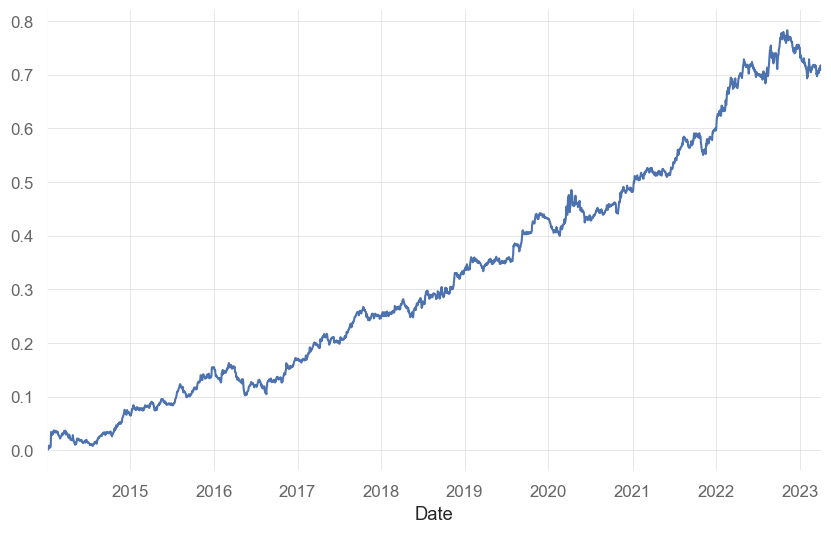

In [533]:

signal = alpha.unstack().reindex_like(P)[P].copy()
# signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.001,0.99).apply(norm.ppf).loc['2016':]
# signal = signal[signal.abs()>1]
# signal = signal.groupby(GICS['gicsect'],axis=1).apply(center)
signal = signal[P].sub(signal.mean(1),0).loc['2014':]
signal = signal[P].div(signal.abs().sum(1),0)
pnl = (signal[P].shift()*R).dropna(axis=0,how = 'all').sum(1)
pnl.cumsum().plot()
pd.Series({"sharpe":sharpe(pnl),
           'turnover':signal.diff().abs().sum().mean()*100,
           'biais' : pnl[pnl!=0].mean()*1e4})

In [11]:
fundamental_features = pd.read_parquet('data/US/fundamental_features.pq')
Y = market_features[['monthly_returns']].groupby(level=1).shift(21).dropna()
data = Y.join(fundamental_features.drop(['CASH','MVE'],axis=1),how = 'left')
data = data.dropna() 
data

In [2]:
from linearmodels.panel.model import RandomEffects


model = RandomEffects()